# Politics On Reddit:  A Journey Into the Dark Side of the America Political Landscape
By: Aryeh Gelfand(https://git.generalassemb.ly/aryehgelfand)

## Problem Statement

AmericanPolitics Debate.com is having a massive problem. A hacker broke into their system and mixed up the files for the Liberal and Conservative Political Discussion groups. I have been tasked with creating a model that can input text from the mixed up group and output an accurate prediction about which group it came from. 

##  Executive Summary

I used data scraped from reddit.com. Specifically the subreddits, r/Conservative and r/The Liberal. In cleaning and modeling the data, I gained valuable insight into the patterns of liberal and conservative discussion groups and those who particpate in them. I was able to answer questions like: 
who uses more profanity?
which group has livelier discssions? 
who has longer posts? 
what topics do each discuss? 
The more I dug into this data, the more it became clear tht the groups followed different patterns of behavior. Delving into the similarities and differences is what made this an interesting project for me. 

At the end, the role of moderation in determining the contents and direction of these discussion groups cannot be overstated. they could even be considered the most important factor.

## Table of Contents

1. [Loading Data](#Loading-Data)
2. [Data Cleaning](#Data-Cleaning)
3. [EDA](#EDA)
4. [Modeling](#Modeling )
5. [Model Prep](#Model-Prep )
   1. [Baseline Model](#Baseline-Model)
   2. [Logistic Regression](#Logistic-Regression)
   3. [KNnearest Neighbors](#KNnearest-Neighbors)
   4. [Decision Trees](#Forest-Forest)
   5. [Random Forest](#Model-Selection)
   6. [ADABoost](#ADABoost)
   7. [SVC](#SVC)
6. [Model Selection](#Model-Selection)
7. [Model Evaluation](#Model-Evaluation)
8. [Conclusions/Recommendations](#Conclusions/Recommendations)
9. [Data Dictionary](#Data-Dictionary)
10. [References](#References)

## Loading Data

In [1]:
import pandas as pd
import numpy as np
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
import matplotlib.pyplot as plt
import wordninja
from sklearn.metrics import confusion_matrix
import regex as re
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
import nltk
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.svm import SVC


from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,TfidfTransformer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS as stopwords
from nltk.corpus import stopwords

## Data Cleaning

We should be able to answer the problem statement and create an accurate model with the data that we have. The only issue may be in determining if the data is too similiar 

In [2]:
l_data = pd.read_csv('../data/liberal_results_df.csv')
c_data = pd.read_csv('../data/conservative_results.csv')               

c_data.shape

(1422, 9)

Data was collected from the Reddit API and has 9 columns.


In [3]:
l_data.head()

,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp
0,What do you think of men’s rights?,[removed],Liberal,1582944269,Benjaminmalchow,0,1,True,2020-02-28
1,Just a thought,[removed],Liberal,1582948063,redneckfarmdude,0,1,True,2020-02-28
2,Screw Conservatives,[removed],Liberal,1582955795,sparklepig7,0,1,True,2020-02-29
3,So far I’ve stumped everyone with this question:,[removed],Liberal,1582982284,CloudofAVALANCHE,0,1,True,2020-02-29
4,I want to become more well-versed.,[removed],Liberal,1582985920,the_shrimp_boi,0,1,True,2020-02-29


In [4]:
c_data.head()

,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp
0,I think it’s important to criticize the White ...,[removed],Conservative,1582934831,T0mThomas,0,1,True,2020-02-28
1,What hot topic policy debates are ongoing with...,[removed],Conservative,1582935206,reevener,0,1,True,2020-02-28
2,Blast from the past....,[removed],Conservative,1582935790,Philip_Glasssss,0,1,True,2020-02-28
3,Imagine Bernie VS Trump,[removed],Conservative,1582937341,S1SSYL1GHTN1NG,0,1,True,2020-02-28
4,'Islamophobia' Is Not A Real Word,[removed],Conservative,1582937694,SpeedForceNirvana,0,1,True,2020-02-28


The posts are divided into title and selftelf columns. These will have to be merged in order to capture all of the words in the dataframe. The author's reddit username, the date posted, and number of comments are also include din our data.

In [5]:

l_data.drop(l_data.index[[814]], inplace=True)
# during eda it was discovered that this cell contained unusable data.


In [6]:


l_data['selftext'] = l_data['selftext'].fillna('[removed]')
c_data['selftext'] = c_data['selftext'].fillna('[removed]')# fill empty columns with removed 


In [7]:
l_data['selftext'] = l_data['selftext'].apply(lambda x : x.replace('[removed]',''))
c_data['selftext'] = c_data['selftext'].apply(lambda x : x.replace('[removed]',''))#remove empty columns


In [8]:
l_data['fulltext'] = l_data['title'] + ' ' + l_data['selftext']
c_data['fulltext'] = c_data['title'] + ' ' + c_data['selftext']# combine text from title and selftext


In order to fix the issue created by having many posts removed in the selftext column, I added removed to all and then removed it from all. Then I created a new column called fulltext that combines the data from both columns. 

In [9]:
c_categorical_nums = {"subreddit": {'Conservative': 0}}#make classification categories
l_categorical_nums = {"subreddit": {'Liberal': 1}}
c_data.replace(c_categorical_nums, inplace=True)
l_data.replace(l_categorical_nums, inplace=True)

I established out target variable and made it 1 and 0 respectively. Since Liberal is the dominant column, I made it the target.

In [10]:

def get_len(post):
    return len(post.split())
l_data['post_len'] = l_data['fulltext'].map(get_len)# create a column that has the length of the posts
c_data['post_len'] = c_data['fulltext'].map(get_len)
#courtesy of markel jones-francis


I created a new column called post_length that measures post length for our combined column

In [11]:
l_data['author'] = l_data['author'].apply(lambda x : x.replace('[deleted]',' '))
c_data['author'] = c_data['author'].apply(lambda x : x.replace('[deleted]',' '))# delete empty author entries

I deleted columns that had the author removed.

In [12]:
def remove_links_lower_and_nums(data,col):
    string = []
    letters = []
    remove_links = []
    for i in data[col]:
        string.append(str(i))
    for j in string:
        letters.append(re.sub(r'[^A-Za-z0-9 ]+', "", j))#remove letters and number
    for k in letters:
        remove_links.append(re.sub(r'(http|ftp|https):\/\/)?[\w\-_]+(\.[\w\-_]+)+([\w\-\.,@?^=%&amp;:/~\+#]*[\w\-\@?^=%&amp;/~\+#])?','',k))#remove links
    return remove_links
    l_data['fulltext'] = remove_links_lower_and_nums(l_data,'fulltext')
    c_data['fulltext'] = remove_links_lower_and_nums(c_data,'fulltext')



I used a regex pattern to remove non letters, numbers, non alphanumeric characters, and links, as these will not be useful words that can give meaning to our text.

In [13]:
def make_str_remove_non_letters_lower(data,col):
    string = []
    for i in data[col]:
        string.append(str(i))
    long_words = []
    for i in string:
        long_words.append(re.sub(r'/.{20,}/','',i))#remove words longer than 20 chars
    lower = []
    for i in long_words:
        lower.append(i.lower())
    return lower
l_data['fulltext'] = make_str_remove_non_letters_lower(l_data,'fulltext')
c_data['fulltext'] = make_str_remove_non_letters_lower(c_data,'fulltext')

    


I removed words longer than 20 characters in order to further prevent link text from being included in our data.

In [14]:
def remove_nums(data,col):# during eda we discovered that a lot of numeric columns has corrupted or non valuble data
    data[col] = data[col].str.replace(r'\d+','')
remove_nums(c_data,'fulltext')
remove_nums(l_data,'fulltext')

During EDA it was discovered that numbers were still included in the text, so I removed them with a regex pattern.

In [15]:
def remove_underscores(data,col):# during eda we discovered that underscores were corrupting the values
    data[col] = data[col].str.replace('_',' ')
remove_underscores(c_data,'fulltext')
remove_underscores(l_data,'fulltext')

Underscores were still being include din the text, here I remove them.
I also removed an offensive word that I did not want to take out because it is relevant in showing the role of moderation or lack of it and how it will become the most important factor  in my model's ability to classify.

In [16]:
def remove_profanity(data,col):# during eda we discovered that underscores were corrupting the values
    data[col] = data[col].str.replace('libtard','lib**')# censoring offensive malterial
remove_underscores(c_data,'fulltext')
remove_underscores(l_data,'fulltext')

In [17]:


def remove_link_words(data,col): # during eda we discovered that link words were still in the dataset 
    data[col] = data[col].str.replace('https','')
    data[col] = data[col].str.replace('http','')
remove_link_words(c_data,'fulltext')
remove_link_words(l_data,'fulltext')

Words associated with links, were still included in our words, here I remove them. Sometimes different types of text can be resistent to tactics and it is therefore neccesary to use a multifacted approach to data cleaning.

## EDA

Text(12, 0, '       Average Length of a Post 61.5 Words')

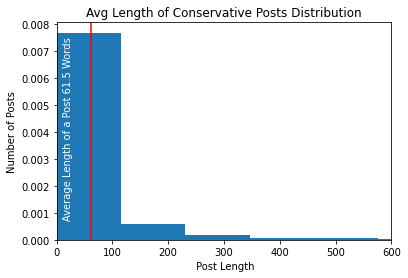

In [18]:
plt.hist(c_data['post_len'],bins =50,density = 5)
plt.title('Avg Length of Conservative Posts Distribution')
plt.xlim(0,600)
plt.xlabel(' Post Length')
plt.ylabel('Number of Posts')
plt.axvline(x=(c_data['post_len'].mean()),color = 'r')
plt.text(12,0, '       Average Length of a Post 61.5 Words',rotation=90, color = 'white')

Here is the average length of posts with the mean in red for the conservative subreddit. The average length is 61 characters and the data is skewed right.

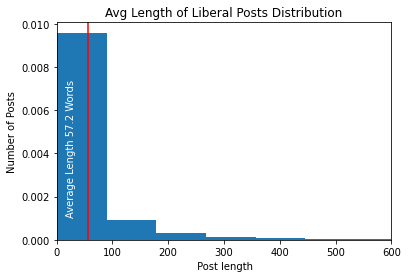

<Figure size 1080x1296 with 0 Axes>

In [19]:
plt.hist(l_data['post_len'],bins =50,density = 5)
plt.title('Avg Length of Liberal Posts Distribution')
plt.xlim(0,600)
plt.xlabel(' Post length')
plt.ylabel('Number of Posts')
plt.axvline(x=(l_data['post_len'].mean()),color = 'r')
plt.text(16,0, '        Average Length 57.2 Words',rotation=90,color='white')
plt.figure(figsize=(15,18))
plt.show();

Here is the average length of posts with the mean in red for the liberal subreddit. The average length is 57 words and the data is skewed r

In [20]:


from better_profanity import profanity
def profanity_counter(data,col):
    counter = 0
    for i in data[col]:
        if profanity.contains_profanity(i) == True:
            counter += 1
    return counter
l_swear = profanity_counter(l_data,'fulltext')
c_swear = profanity_counter(c_data,'fulltext')   



I imported a library of profanity and counted every instance of profanity for each subreddit.

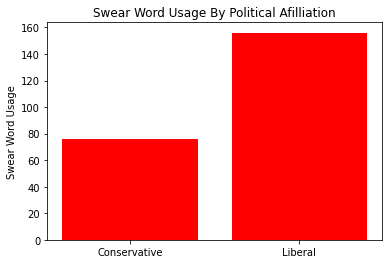

In [21]:
x = ['Conservative', 'Liberal']
y = [76,156]
plt.bar(x,y,color = 'r');
plt.ylabel('Swear Word Usage')
plt.title('Swear Word Usage By Political Afilliation');

The liberal subreddit has double the amount of profanity. This could be because the members post more profanity or it could be that there is a lack of moderation by leaders and therefore offending posts are not deleted when compared to the conservative subreddit.

In [22]:
stopwords = nltk.corpus.stopwords.words('english')
newStopWords = ['the','of','to','in','than','$','?','(',')''is','www','for','us','amp','conservative', 'conservatives','liberal','liberals','think','know','would','trump','want','pm ing','com','country','like','get','even','new','news','see','people','president','left','right','good','government','time','one','say','amb xb','xb','yeah','oh','goo','gl','enzhg','youtube','wikipedia','fuck','fucker','libtard','libtards']#new stop words list
stopwords.extend(newStopWords)# stop words censored do not look through list
l_data['fulltext'] = [' '.join([y for y in x.split() if y not in stopwords]) for x in l_data['fulltext']]
c_data['fulltext'] = [' '.join([y for y in x.split() if y not in stopwords]) for x in c_data['fulltext']]

Here is a custom list of stop words that I curated by plotting the most common words in each subreddit and then using the most misclassified terms. I looked for words that appeared in both. I also removed offensive words that it did not have an important role in classification

In [23]:

both_df = c_data[c_data['author'].isin(l_data['author'])]
both_df = both_df[both_df['author'] != ' ']



I wanted to see if there were people posting in both that were not representative of the group they were posting in. I created a new dataframe of authors that appear in both and what they posted.

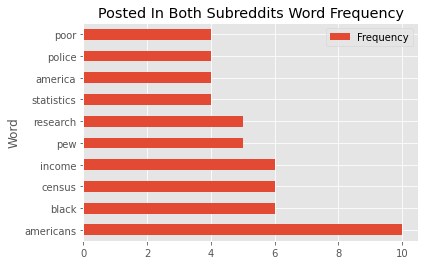

In [24]:
def get_top_ten_words_remove_stop_words(data,col):
    top_N = 10
    txt = data[col].str.lower().str.replace(r'[^A-Za-z0-9 ]+', ' ').str.cat(sep=' ')
    words = nltk.tokenize.word_tokenize(txt)
    word_dist = nltk.FreqDist(words)
    words_except_stop_dist = nltk.FreqDist(w for w in words if w not in stopwords) 
    rslt = pd.DataFrame(word_dist.most_common(top_N),
                    columns=['Common Word', 'Frequency'])
    rslt = pd.DataFrame(words_except_stop_dist.most_common(top_N),
                    columns=['Word', 'Frequency']).set_index('Word')
    plt.style.use('ggplot')

    rslt.plot.barh(title = 'Posted In Both Subreddits Word Frequency');
get_top_ten_words_remove_stop_words(both_df,'fulltext')
# adapted from https://stackoverflow.com/questions/40206249/count-of-most-popular-words-in-a-pandas-dataframe

These authors that post in both are not represtative of the common values in either group and therefore, I must remove them from the combined dataframe that will go into the model.

In [25]:
c_combine  = c_data.copy()
l_combine = l_data.copy()# make a copy of the data for eda


In [26]:
cvec = CountVectorizer(analyzer = "word",
                             tokenizer = None,
                             preprocessor = None,
                             stop_words = stopwords,
                             ngram_range = (1,2),
                       
                             max_features = 50000)

l_cvec = cvec.fit_transform(l_data['fulltext'])
l_df = pd.DataFrame(l_cvec.toarray(),
                          columns=cvec.get_feature_names())


/Users/aryehgelfand/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['amb', 'ing', 'pm'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [27]:
cvec = CountVectorizer(analyzer = "word",
                             tokenizer = None,
                             preprocessor = None,
                             stop_words = stopwords,
                             ngram_range = (1,2),
                       
                             max_features = 50000)

In [28]:
c_cvec = cvec.fit_transform(c_data['fulltext'])
c_df = pd.DataFrame(c_cvec.toarray(),
                          columns=cvec.get_feature_names())

/Users/aryehgelfand/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['amb', 'ing', 'pm'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


I count vectorized each dataframe with an n gram of 1,2 meaning it is checking unigrams in each post. So, we can see which words are common or words that need to be removed.

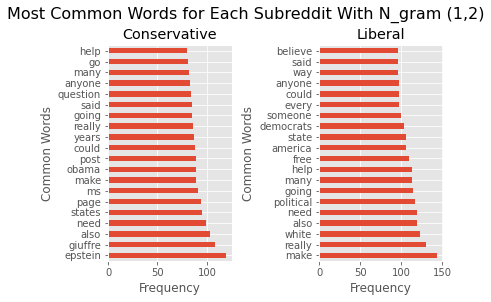

<Figure size 432x288 with 0 Axes>

In [29]:


fig,axes=plt.subplots(ncols=2)
plt.suptitle('Most Common Words for Each Subreddit With N_gram (1,2)',fontsize=16,va='bottom')
axes[0].set(xlabel="Frequency", ylabel="Common Words")
axes[1].set(xlabel="Frequency", ylabel="Common Words")
axes[0].title.set_text('Conservative')
axes[1].title.set_text('Liberal')
c_df.sum().sort_values(ascending=False).head(20).plot(kind='barh', ax= axes[0]);

l_df.sum().sort_values(ascending=False).head(20).plot(kind='barh', ax = axes[1]);

plt.tight_layout()
plt.figure();

The most common words after addding a lot of similiar words to the stop list are unique to each. When I first did this, the most common words were Trump, and other very generic terms. By removing these terms, Imade it easier for the model to classsify each. Another interesting note is that epstein and a mispelling of Jeffrey('guiffre') ,is prominent on the conservative subreddit, but not in the Liberal one.
I also removed a lot of slurs and other offensive words. Mostly from the liberal side. This tells me that the conservative subreddit is doing more robust moderation of their page. 

In [30]:
cvec = CountVectorizer(analyzer = "word",
                             tokenizer = None,
                             preprocessor = None,
                             stop_words = stopwords,
                             ngram_range = (2,2),
                       
                             max_features = 50000)
l_cvec = cvec.fit_transform(l_data['fulltext'])
l_df = pd.DataFrame(l_cvec.toarray(),
                          columns=cvec.get_feature_names())

/Users/aryehgelfand/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['amb', 'ing', 'pm'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [31]:
cvec = CountVectorizer(analyzer = "word",
                             tokenizer = None,
                             preprocessor = None,
                             stop_words = stopwords,
                             ngram_range = (2,2),
                       
                             max_features = 50000)
c_cvec = cvec.fit_transform(c_data['fulltext'])
c_df = pd.DataFrame(c_cvec.toarray(),
                          columns=cvec.get_feature_names())

/Users/aryehgelfand/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['amb', 'ing', 'pm'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


These count vectorizers are checkong for bigrams in each post. Meaning unique two word combinations. We can get a better sense of the meaning of the common posts post

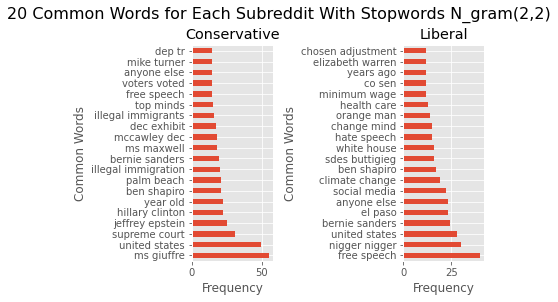

<Figure size 432x288 with 0 Axes>

In [32]:
fig,axes=plt.subplots(ncols=2)
plt.suptitle('20 Common Words for Each Subreddit With Stopwords N_gram(2,2)',fontsize=16,va='bottom')
axes[0].set(xlabel="Frequency", ylabel="Common Words")
axes[1].set(xlabel="Frequency", ylabel="Common Words")
axes[0].title.set_text('Conservative')
axes[1].title.set_text('Liberal')
c_df.sum().sort_values(ascending=False).head(20).plot(kind='barh', ax= axes[0]);

l_df.sum().sort_values(ascending=False).head(20).plot(kind='barh', ax = axes[1]);

plt.tight_layout()
plt.figure();

These bigrams are all pertaining to a particular contentious issue for either group. This came about after I removed many unique and profane words. 

In [33]:
full_df = pd.concat([l_combine,c_combine])# combine the dataframes into one that one can go in the model.


In [34]:
full_df = full_df[~full_df['author'].isin(both_df['author'])]# removed posts from authors who posted in both

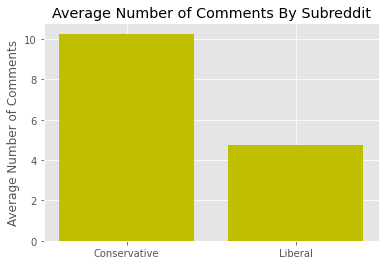

In [35]:
#plt.bar(full_df['subreddit'],full_df['num_comments'].mean())
full_df[full_df['subreddit']==1]['num_comments'].mean()
x = ['Conservative', 'Liberal']
y = [full_df[full_df['subreddit']==0]['num_comments'].mean(),full_df[full_df['subreddit']==1]['num_comments'].mean()]
plt.bar(x,y,color = 'y');
plt.ylabel('Average Number of Comments')
plt.title('Average Number of Comments By Subreddit');

Check for average comments per post for each group. Conservatives have a livlier discussion on average

# Modeling

### Model Prep

In [36]:
X = full_df['fulltext']
y = full_df['subreddit']

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X,# split the dataframe into a training and testing set in order to check for overfitting
                                                    y,
                                                    test_size=0.25,
             
                                                    stratify=y,

                                                   random_state=42)




We split the data into 75% training set in order to train our model and 25% to test the model. We do this to avoid overfitting our data to one set of data.

#### Baseline Model

In [38]:
y_test.value_counts(normalize=True)[1
                                   
                                   ]

0.5504469987228607

The baseline model is without any optimization if we would randomly choose selections from the datset, we would on average pick the Liberal subreddit 55.04% of the time. In order to be successful, our model needs to outdo this.

#### Logistic Regression

In [39]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression(solver = 'liblinear'))
])

pipe_params = {
    'cvec__min_df': [1,2, 3],
    'cvec__max_features': [2372],
    'cvec__max_df': [.6,.8],
    'cvec__ngram_range': [(1,5),(1,4),(2,2)],
    'cvec__stop_words': [stopwords,'english'],
    'lr__penalty':['l1','l2'],
    'lr__C':[.01,1,10]
}

gs = GridSearchCV(pipe, # what object are we optimizing?
                  param_grid=pipe_params,
                  n_jobs=-1,# what parameters values are we searching?
                  cv=3,
                 verbose=1) # 5-fold cross-validation.

In [40]:
gs.fit(X_train,y_train)

Fitting 3 folds for each of 216 candidates, totalling 648 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 648 out of 648 | elapsed:  3.8min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('cvec',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                            

In [41]:
gs.get_params



<bound method BaseEstimator.get_params of GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('cvec',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
  

In [42]:
print(f'Train Score {gs.score(X_train,y_train)}')
print(f'Test Score {gs.score(X_test,y_test)}')
print(f'Cross Val Score {cross_val_score(gs.best_estimator_, X_train,y_train).mean()}')


Train Score 0.804005112910098
Test Score 0.5977011494252874


/Users/aryehgelfand/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Cross Val Score 0.595658053326278


In [43]:
tvec_pipe = Pipeline([
    ('tvec' , TfidfVectorizer()),
    ('lr', LogisticRegression(solver = 'liblinear'))
])


In [44]:
tvec_pipe_params = {
    'tvec__stop_words': [stopwords],# there was too much profanity in the dataset, so in the name of professionalism, I had to remove profane words by making it choose my stop word list.
    'tvec__ngram_range': [(1,1), (1,2)],
    'lr__penalty':['l2'],
    'lr__C':[.01,1,10]
}

In [45]:
best_score = GridSearchCV(tvec_pipe, # what object are we optimizing?
                  param_grid=tvec_pipe_params, # what parameters values are we searching?
                  cv=5,
                 verbose = 1,
                 n_jobs=-1) # 5-fold cross-validation.

In [46]:
best_score.fit(X_train,y_train)


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.4s finished
/Users/aryehgelfand/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['amb', 'ing', 'pm'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('tvec',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                          

In [47]:
best_score.best_params_


{'lr__C': 1,
 'lr__penalty': 'l2',
 'tvec__ngram_range': (1, 1),
 'tvec__stop_words': ['i',
  'me',
  'my',
  'myself',
  'we',
  'our',
  'ours',
  'ourselves',
  'you',
  "you're",
  "you've",
  "you'll",
  "you'd",
  'your',
  'yours',
  'yourself',
  'yourselves',
  'he',
  'him',
  'his',
  'himself',
  'she',
  "she's",
  'her',
  'hers',
  'herself',
  'it',
  "it's",
  'its',
  'itself',
  'they',
  'them',
  'their',
  'theirs',
  'themselves',
  'what',
  'which',
  'who',
  'whom',
  'this',
  'that',
  "that'll",
  'these',
  'those',
  'am',
  'is',
  'are',
  'was',
  'were',
  'be',
  'been',
  'being',
  'have',
  'has',
  'had',
  'having',
  'do',
  'does',
  'did',
  'doing',
  'a',
  'an',
  'the',
  'and',
  'but',
  'if',
  'or',
  'because',
  'as',
  'until',
  'while',
  'of',
  'at',
  'by',
  'for',
  'with',
  'about',
  'against',
  'between',
  'into',
  'through',
  'during',
  'before',
  'after',
  'above',
  'below',
  'to',
  'from',
  'up',
  'down',

In [48]:
print(f'Train Score {best_score.score(X_train,y_train)}')
print(f'Test Score {best_score.score(X_test,y_test)}')
print(f'Cross Val Score {cross_val_score(best_score.best_estimator_, X_train, y_train).mean()}')

Train Score 0.893907115466553
Test Score 0.6372924648786717


/Users/aryehgelfand/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/aryehgelfand/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['amb', 'ing', 'pm'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/Users/aryehgelfand/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['amb', 'ing', 'pm'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Cross Val Score 0.6020442937572608


/Users/aryehgelfand/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['amb', 'ing', 'pm'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


#### KNnearest Neighbors

In [49]:
knn__cvec_pipe = Pipeline([
    ('cvec', CountVectorizer()),
   ( 'tdif', TfidfTransformer(use_idf=False)),
    ('knn' ,KNeighborsClassifier())
])

In [50]:
pipe_params = {
    'cvec__min_df': [3],
    'cvec__max_df': [.6],
    'cvec__ngram_range': [(1,3),(1,4)],
    'cvec__stop_words': [stopwords,'english'],
    'knn__n_neighbors': [3],
    'knn__metric': ['euclidean']
}

In [51]:
gs = GridSearchCV(knn__cvec_pipe, # what object are we optimizing?
                  param_grid=pipe_params,
                  n_jobs = -1,# what parameters values are we searching?
                  cv=3,
                 verbose = 1) # 5-fold cross-validation.

gs.fit(X_train,y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    4.5s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('cvec',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                            

In [52]:
gs.best_params_

{'cvec__max_df': 0.6,
 'cvec__min_df': 3,
 'cvec__ngram_range': (1, 3),
 'cvec__stop_words': 'english',
 'knn__metric': 'euclidean',
 'knn__n_neighbors': 3}

In [53]:
print(f'Train Score {gs.score(X_train,y_train)}')
print(f'Test Score {gs.score(X_test,y_test)}')
print(f'Cross Val Score {cross_val_score(gs.best_estimator_, X,y).mean()}')

Train Score 0.6293140178951854
Test Score 0.5683269476372924


/Users/aryehgelfand/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Cross Val Score 0.549517334529579


In [54]:
knn_tfidf_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ( 'tdif', TfidfTransformer(use_idf=False)),
    ('knn' ,KNeighborsClassifier())
])

In [55]:
pipe_params = {
    'tvec__min_df': [3],
    'tvec__max_df': [.6],
    'tvec__ngram_range': [(1,3)],
    'tvec__stop_words': [stopwords,'english'],
    'knn__n_neighbors': [3],
    'knn__metric': ['euclidean']
}

In [56]:
gs = GridSearchCV(knn_tfidf_pipe, # what object are we optimizing?
                  param_grid=pipe_params,
                  n_jobs = -1,# what parameters values are we searching?
                  cv=3,
                 verbose = 1) # 5-fold cross-validation.

gs.fit(X_train,y_train)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    2.0s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('tvec',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                          

In [57]:
gs.best_params_

{'knn__metric': 'euclidean',
 'knn__n_neighbors': 3,
 'tvec__max_df': 0.6,
 'tvec__min_df': 3,
 'tvec__ngram_range': (1, 3),
 'tvec__stop_words': 'english'}

In [58]:
print(f'Train Score {gs.score(X_train,y_train)}')
print(f'Test Score {gs.score(X_test,y_test)}')
print(f'Cross Val Score {cross_val_score(gs.best_estimator_, X,y).mean()}')

Train Score 0.6246271836386876
Test Score 0.5606641123882503


/Users/aryehgelfand/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Cross Val Score 0.5498427476387633


#### Decision Trees

In [59]:
pipe_dt_cvec = Pipeline([
    ('cvec', CountVectorizer()),
    ('dt', DecisionTreeClassifier())])


pipe_params = {
    'cvec__min_df': [3] ,
    'cvec__max_df' : [.6],
    'cvec__ngram_range': [(1,3)],
    'cvec__stop_words' : ['english', stopwords],
    'dt__max_depth' : [20],
    'dt__min_samples_leaf' : [6],
    'dt__min_samples_split' : [3],
    }

gs = GridSearchCV(pipe_dt_cvec, # what object are we optimizing?
                  param_grid=pipe_params,
                  n_jobs = -1,# what parameters values are we searching?
                  cv=3,
                  verbose = 1) # 3-fold cross-validation.

In [60]:
gs.fit(X_train,y_train)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    2.0s finished
/Users/aryehgelfand/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['amb', 'ing', 'pm'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('cvec',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                            

In [61]:


gs.best_params_

{'cvec__max_df': 0.6,
 'cvec__min_df': 3,
 'cvec__ngram_range': (1, 3),
 'cvec__stop_words': ['i',
  'me',
  'my',
  'myself',
  'we',
  'our',
  'ours',
  'ourselves',
  'you',
  "you're",
  "you've",
  "you'll",
  "you'd",
  'your',
  'yours',
  'yourself',
  'yourselves',
  'he',
  'him',
  'his',
  'himself',
  'she',
  "she's",
  'her',
  'hers',
  'herself',
  'it',
  "it's",
  'its',
  'itself',
  'they',
  'them',
  'their',
  'theirs',
  'themselves',
  'what',
  'which',
  'who',
  'whom',
  'this',
  'that',
  "that'll",
  'these',
  'those',
  'am',
  'is',
  'are',
  'was',
  'were',
  'be',
  'been',
  'being',
  'have',
  'has',
  'had',
  'having',
  'do',
  'does',
  'did',
  'doing',
  'a',
  'an',
  'the',
  'and',
  'but',
  'if',
  'or',
  'because',
  'as',
  'until',
  'while',
  'of',
  'at',
  'by',
  'for',
  'with',
  'about',
  'against',
  'between',
  'into',
  'through',
  'during',
  'before',
  'after',
  'above',
  'below',
  'to',
  'from',
  'up',
  

In [62]:
print(f'Train Score {gs.score(X_train,y_train)}')
print(f'Test Score {gs.score(X_test,y_test)}')
print(f'Cross Val Score {cross_val_score(gs.best_estimator_, X,y).mean()}')




Train Score 0.6229228802726885
Test Score 0.5721583652618135


/Users/aryehgelfand/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/aryehgelfand/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['amb', 'ing', 'pm'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/Users/aryehgelfand/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['amb', 'ing', 'pm'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/Users/aryehgelfand/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words

Cross Val Score 0.5472835665767031


In [63]:
dt_tfidf_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ( 'tdif', TfidfTransformer(use_idf=False)),
    ('dt' ,DecisionTreeClassifier())
])

pipe_params = {
    'tvec__min_df': [3] ,
    'tvec__max_df' : [.6],
    'tvec__ngram_range': [(1,3)],
    'tvec__stop_words' : ['english', stopwords],
    'dt__max_depth' : [20],
    'dt__min_samples_leaf' : [6],
    'dt__min_samples_split' : [3],
    }

gs = GridSearchCV(dt_tfidf_pipe, # what object are we optimizing?
                  param_grid=pipe_params,
                  n_jobs = -1,# what parameters values are we searching?
                  cv=3,
                  verbose = 1) # 3-fold cross-validation.

In [64]:
gs.fit(X_train,y_train)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    1.9s finished
/Users/aryehgelfand/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['amb', 'ing', 'pm'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('tvec',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                          

In [65]:
gs.best_params_

{'dt__max_depth': 20,
 'dt__min_samples_leaf': 6,
 'dt__min_samples_split': 3,
 'tvec__max_df': 0.6,
 'tvec__min_df': 3,
 'tvec__ngram_range': (1, 3),
 'tvec__stop_words': ['i',
  'me',
  'my',
  'myself',
  'we',
  'our',
  'ours',
  'ourselves',
  'you',
  "you're",
  "you've",
  "you'll",
  "you'd",
  'your',
  'yours',
  'yourself',
  'yourselves',
  'he',
  'him',
  'his',
  'himself',
  'she',
  "she's",
  'her',
  'hers',
  'herself',
  'it',
  "it's",
  'its',
  'itself',
  'they',
  'them',
  'their',
  'theirs',
  'themselves',
  'what',
  'which',
  'who',
  'whom',
  'this',
  'that',
  "that'll",
  'these',
  'those',
  'am',
  'is',
  'are',
  'was',
  'were',
  'be',
  'been',
  'being',
  'have',
  'has',
  'had',
  'having',
  'do',
  'does',
  'did',
  'doing',
  'a',
  'an',
  'the',
  'and',
  'but',
  'if',
  'or',
  'because',
  'as',
  'until',
  'while',
  'of',
  'at',
  'by',
  'for',
  'with',
  'about',
  'against',
  'between',
  'into',
  'through',
  'dur

In [66]:
print(f'Train Score {gs.score(X_train,y_train)}')
print(f'Test Score {gs.score(X_test,y_test)}')
print(f'Cross Val Score {cross_val_score(gs.best_estimator_, X,y).mean()}')

Train Score 0.6335747763101832
Test Score 0.578544061302682


/Users/aryehgelfand/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/aryehgelfand/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['amb', 'ing', 'pm'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/Users/aryehgelfand/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['amb', 'ing', 'pm'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/Users/aryehgelfand/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words

Cross Val Score 0.5482414209828333


#### Bagging


In [67]:
bag_pipe_cvec = Pipeline([
    ('cvec', CountVectorizer()),
    ('bag', BaggingClassifier())])

pipe_params = {
    'cvec__min_df': [3] ,
    'cvec__max_df' : [.6],
    'cvec__ngram_range': [(1,3)],
    'cvec__stop_words' : ['english', stopwords],
    'bag__n_estimators': [20,30,5],
    'bag__max_features': [.1,.5,.9]
    }
gs = GridSearchCV(bag_pipe_cvec, # what object are we optimizing?
                  param_grid=pipe_params,
                  n_jobs = -1,# what parameters values are we searching?
                  cv=3,
                  verbose = 1) # 3-fold cross-validation.

In [68]:
gs.fit(X_train,y_train)


Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   35.5s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   53.3s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('cvec',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                            

In [69]:
gs.best_params_

{'bag__max_features': 0.1,
 'bag__n_estimators': 30,
 'cvec__max_df': 0.6,
 'cvec__min_df': 3,
 'cvec__ngram_range': (1, 3),
 'cvec__stop_words': 'english'}

In [70]:
print(f'Train Score {gs.score(X_train,y_train)}')
print(f'Test Score {gs.score(X_test,y_test)}')
print(f'Cross Val Score {cross_val_score(gs.best_estimator_, X,y).mean()}')

Train Score 0.8662121857690669
Test Score 0.6104725415070242


/Users/aryehgelfand/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Cross Val Score 0.5447348036367826


In [71]:
bag_pipe_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('bag', BaggingClassifier())])

pipe_params = {
    'tvec__min_df': [3] ,
    'tvec__max_df' : [.6],
    'tvec__ngram_range': [(1,3),(1,4),(2,2)],
    'tvec__stop_words' : ['english', stopwords],
    'bag__n_estimators': [20,30,5],
    'bag__max_features': [.1,.5,.9]
    }
gs = GridSearchCV(bag_pipe_tvec, # what object are we optimizing?
                  param_grid=pipe_params,
                  n_jobs = -1,# what parameters values are we searching?
                  cv=3,
                  verbose = 1) # 3-fold cross-validation.

In [72]:
gs.fit(X_train,y_train)

Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:  2.2min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('tvec',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                          

In [73]:
gs.best_params_

{'bag__max_features': 0.5,
 'bag__n_estimators': 20,
 'tvec__max_df': 0.6,
 'tvec__min_df': 3,
 'tvec__ngram_range': (1, 4),
 'tvec__stop_words': 'english'}

In [74]:
print(f'Train Score {gs.score(X_train,y_train)}')
print(f'Test Score {gs.score(X_test,y_test)}')
print(f'Cross Val Score {cross_val_score(gs.best_estimator_, X,y).mean()}')

Train Score 0.9731572219855135
Test Score 0.6040868454661558


/Users/aryehgelfand/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Cross Val Score 0.5584683399396484


#### Random Forest


In [75]:
rf_cvec = Pipeline([
    ('cvec', CountVectorizer()),
    ('rf', RandomForestClassifier())])

rf_params = {
    'cvec__min_df': [3] ,
    'cvec__max_df' : [.6],
    'cvec__ngram_range': [(1,3),(1,4),(2,2)],
    'cvec__stop_words' : ['english', stopwords],
    'rf__max_depth':[3,5],
    'rf__n_estimators':[10,100]
    
}
gs = GridSearchCV(rf_cvec, param_grid=rf_params, cv=5)
gs.fit(X_train, y_train)



/Users/aryehgelfand/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['amb', 'ing', 'pm'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/Users/aryehgelfand/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['amb', 'ing', 'pm'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/Users/aryehgelfand/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['amb', 'ing', 'pm'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/Users/aryehgelfand/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: U

/Users/aryehgelfand/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['amb', 'ing', 'pm'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/Users/aryehgelfand/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['amb', 'ing', 'pm'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/Users/aryehgelfand/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['amb', 'ing', 'pm'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/Users/aryehgelfand/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: U

/Users/aryehgelfand/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['amb', 'ing', 'pm'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/Users/aryehgelfand/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['amb', 'ing', 'pm'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/Users/aryehgelfand/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['amb', 'ing', 'pm'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/Users/aryehgelfand/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: U

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('cvec',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                            

In [76]:

gs.best_params_

{'cvec__max_df': 0.6,
 'cvec__min_df': 3,
 'cvec__ngram_range': (1, 4),
 'cvec__stop_words': 'english',
 'rf__max_depth': 5,
 'rf__n_estimators': 10}

In [77]:
print(f'Train Score {gs.score(X_train,y_train)}')
print(f'Test Score {gs.score(X_test,y_test)}')
print(f'Cross Val Score {cross_val_score(gs.best_estimator_, X,y).mean()}')

Train Score 0.5905411163187048
Test Score 0.5670498084291188


/Users/aryehgelfand/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Cross Val Score 0.5514397844796944


In [78]:
rf_tvec = Pipeline([
    ('tvec', CountVectorizer()),
    ('rf', RandomForestClassifier())])

rf_params = {
    'tvec__min_df': [3] ,
    'tvec__max_df' : [.6],
    'tvec__ngram_range': [(1,3),(1,4),(2,2)],
    'tvec__stop_words' : ('english', stopwords),
    'rf__max_depth':[3,5],
    'rf__n_estimators':[10,100]
    
}
gs = GridSearchCV(rf_tvec, param_grid=rf_params, cv=3)
gs.fit(X_train, y_train)




/Users/aryehgelfand/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['amb', 'ing', 'pm'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/Users/aryehgelfand/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['amb', 'ing', 'pm'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/Users/aryehgelfand/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['amb', 'ing', 'pm'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/Users/aryehgelfand/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: U

/Users/aryehgelfand/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['amb', 'ing', 'pm'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/Users/aryehgelfand/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['amb', 'ing', 'pm'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/Users/aryehgelfand/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['amb', 'ing', 'pm'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/Users/aryehgelfand/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: U

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('tvec',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                            

In [79]:
print(f'Train Score {gs.score(X_train,y_train)}')
print(f'Test Score {gs.score(X_test,y_test)}')
print(f'Cross Val Score {cross_val_score(gs.best_estimator_, X,y).mean()}')

Train Score 0.5803152961227098
Test Score 0.5568326947637292


/Users/aryehgelfand/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Cross Val Score 0.5492035652039623


#### ADA Boost

In [80]:
ada_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ( 'tdif', TfidfTransformer(use_idf=False)),
    ('ada', AdaBoostClassifier())])

ada_params = {
    'cvec__min_df': [3] ,
    'cvec__max_df' : [.6],
    'cvec__ngram_range': [(1,3),(1,4),(2,2)],
    'cvec__stop_words' : ['english', stopwords],
    'ada__n_estimators' : [25,50,75],
    'ada__learning_rate' : [.5,1,1.5]
    
    
}



gs = GridSearchCV(ada_pipe, param_grid=ada_params, cv=3,verbose=1, n_jobs=-1)
gs.fit(X_train, y_train)



Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:  1.1min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('cvec',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                            

In [81]:
gs.best_params_


{'ada__learning_rate': 0.5,
 'ada__n_estimators': 50,
 'cvec__max_df': 0.6,
 'cvec__min_df': 3,
 'cvec__ngram_range': (1, 3),
 'cvec__stop_words': 'english'}

In [82]:
print(f'Train Score {gs.score(X_train,y_train)}')
print(f'Test Score {gs.score(X_test,y_test)}')
print(f'Cross Val Score {cross_val_score(gs.best_estimator_, X,y).mean()}')

Train Score 0.6655304644226673
Test Score 0.5836526181353767


/Users/aryehgelfand/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Cross Val Score 0.5559195769997278


#### SVC

In [83]:
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('svc', SVC())])
pipe_params = {
    'tvec__min_df': [3] ,
    'tvec__max_df' : [.6],
    'tvec__ngram_range': [(1,3)],
    'tvec__stop_words' : ['english', stopwords],
    'svc__gamma' : ['scale'],
    'svc__C': [100,10,.1],
    'svc__kernel':['rbf','linear','poly']

}





gs = GridSearchCV(pipe, param_grid=pipe_params, cv=5)

In [ ]:
gs.fit(X_train,y_train)

/Users/aryehgelfand/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['amb', 'ing', 'pm'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/Users/aryehgelfand/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['amb', 'ing', 'pm'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/Users/aryehgelfand/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['amb', 'ing', 'pm'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/Users/aryehgelfand/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: U

/Users/aryehgelfand/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['amb', 'ing', 'pm'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/Users/aryehgelfand/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['amb', 'ing', 'pm'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/Users/aryehgelfand/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['amb', 'ing', 'pm'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/Users/aryehgelfand/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: U

In [ ]:
print(f'Train Score {gs.score(X_train,y_train)}')
print(f'Test Score {gs.score(X_test,y_test)}')
print(f'Cross Val Score {cross_val_score(gs.best_estimator_, X,y).mean()}')

### Model Selection


|   Model   | Train Accuracy | Test Accuracy|
|-----------|----------|---------|
| Logistic Regression-Cvec    | .88   | .63   |
| Logistic Regression - Tvec   | .88   | .656|
| KNN - Cvec    |.63    |.56|
| KNN -  Tvec    |.63    |.55|
| dt -  Cvec    |.64    |.57|
| dt -  Tvec    |.65    |.57|
| BAGGING -  Cvec    |.96    |.613|
| BAGGING - Tcvec    |.96    |.62|
| Random Forest -  Cvec    |.97    |.63|
| Random Forest - Tcvec    |.97    |.627|
| ADA Boost     |.68    |.61|
| SVC    |.55   |.656|



I am choosing Logistic Regression as my predictive and interpretable model, because it is easy to interpret and had an equally good score to the svc. Once, I took out the profanity and racist comments the score dropped to .637, this tells me that this is what is making the page distinct, probably because of the lack of moderation.

### Model Evaluation

In [ ]:
cvec_coefe = best_score.best_estimator_[1].coef_[0]
cvec_features =best_score.best_estimator_.steps[0][1].get_feature_names()
model_coefe_cvec = pd.Series(cvec_coefe, index = cvec_features)
cvec_preds = best_score.predict(X_test)

Get feature name and coefficents in a dataframe

In [ ]:
#model_coefe_cvec.sort_values(ascending=False).head(20).plot(kind = 'barh')
#plt.title("Words Most Correlated to Liberal Cvec")
#plt.xlabel('Correlation')
#plt.ylabel('Words')

This is the cofficients for my top perforing Logistic regression Model and feature names. It It is the top 20 I am censoring this graph, but it tells us that what is making the liberal class distinct is the lack of moderation of the page. The negative and racist comments are make it different from the conservant class. For example when, I took out profanity and racist words , the accuracy dropped from .66 to .637. There is also the word democrats, and maga, so they are discusing internal and external issues.

The graph tells us that negative comments and racist comments have the highest correlation for predicitng the Liberal class. It also includes words like liberals which are obviously self referencing.

In [ ]:
print(f'1. For every occurance of the word "lib***" a post is {round(np.exp(1.78))} times as likely to be in the Liberal subreddit')
print(f'2. For every occurance of the words "liberals" a post is {round(np.exp(2.5))} times as likely to be in the Liberal subreddit')
print(' I Removed this word but the fact that it has such a large correlation tells us that what makes this class distinct is the lack of moderation on the page')


In [ ]:
model_coefe_cvec.sort_values(ascending=False).tail(20).plot(kind = 'barh')
plt.title("Words Most Correlated to Conservative cvec")
plt.xlabel('Correlation')
plt.ylabel('Words')

In [ ]:
print(f'1. For every occurance of the word "deleted" a post is {round(np.exp(1.8))} times as likely to be in the Conservative subreddit')
print(f'2. For every occurance of the words "cruz" a post is {round(np.exp(2.2))} times as likely to be in the Conservative subreddit')



There page is moderated, the second highest word is deletd meaning they remove any posts that are offensive or they don't agree with. This makes their class very hard to predict, because all the comments are generic about politics and contain the same words as the liberal subreddit. What makes the liberal subreddit unique is the profanity.

In [ ]:
cm = confusion_matrix(y_test, cvec_preds)
cm_df = pd.DataFrame(cm, columns=['Pred Conservative', 'Pred Liberal'], index=['Actual Conservative', 'Actual Liberal'])
cm_df

In [ ]:
confusion_matrix(y_test, # True values.
                 cvec_preds)  # Predicted values.
tn, fp, fn, tp = confusion_matrix(y_test, cvec_preds).ravel()



In [ ]:
print(f'There are {fp} occurances where the mode predicted Liberal but was actually COnservative')
print(f'There are {tn} 157 case where the model predicted conservative and was actually conservative')
print(f'There are {fn} cases where the model predicted Conservative but was actually Liberal')
print(f'There are {tp} cases where the model predicted Liberal and it was Liberal')

In [ ]:
print(f'The Accuracy   is {accuracy_score(y_test,cvec_preds)}')
print(f'The Sensitivity is {tp / (tp + fn)}')
print(f'The Specificity is {tn / (tn + fp)}')



The model was almost double as effective in predicting as conservative for the issues I mentioned earlier.

In [ ]:
preds = pd.DataFrame(cvec_preds)
full = pd.concat([X_test, y_test], axis=1)
full['preds'] = cvec_preds

In [ ]:
misclassified = pd.DataFrame(full['fulltext'].loc[~(full['subreddit'] == full['preds'])])
misclassified_subreddit = pd.DataFrame(full['subreddit'].loc[~(full['subreddit'] == full['preds'])])

In [ ]:
misclassified['subreddit'] = misclassified_subreddit['subreddit']

In [ ]:
misclassified_l = misclassified['fulltext'].loc[misclassified['subreddit'] == 1]
misclassified_c = misclassified['fulltext'].loc[misclassified['subreddit'] == 0]

misclassified_l = pd.DataFrame(misclassified_l)
misclassified_c = pd.DataFrame(misclassified_c)

In [ ]:
cvec = CountVectorizer(analyzer = "word",
                             tokenizer = None,
                             preprocessor = None,
                             stop_words = stopwords,
                             ngram_range = (2,2),
                       
                             max_features = 50000)

lm_cvec = cvec.fit_transform(misclassified_l['fulltext'])
lm_df = pd.DataFrame(lm_cvec.toarray(),
                          columns=cvec.get_feature_names())

In [ ]:
cvec = CountVectorizer(analyzer = "word",
                             tokenizer = None,
                             preprocessor = None,
                             stop_words = stopwords,
                             ngram_range = (1,2),
                       
                             max_features = 50000)

lm_cvec = cvec.fit_transform(misclassified_l['fulltext'])
lm_df = pd.DataFrame(lm_cvec.toarray(),
                          columns=cvec.get_feature_names())

cvec = CountVectorizer(analyzer = "word",
                             tokenizer = None,
                             preprocessor = None,
                             stop_words = stopwords,
                             ngram_range = (1,2),
                       
                             max_features = 50000)

cm_cvec = cvec.fit_transform(misclassified_c['fulltext'])
cm_df = pd.DataFrame(cm_cvec.toarray(),
                          columns=cvec.get_feature_names())

In [ ]:
ig,axes=plt.subplots(ncols=2)
plt.suptitle('Most Common Misclassified Posts for Each Subreddit With N_gram (1,2)',fontsize=16,va='bottom')
axes[0].set(xlabel="Frequency", ylabel="Common Words")
axes[1].set(xlabel="Frequency", ylabel="Common Words")
axes[0].title.set_text('Conservative')
axes[1].title.set_text('Liberal')
cm_df.sum().sort_values(ascending=False).head(20).plot(kind='barh', ax= axes[0]);

lm_df.sum().sort_values(ascending=False).head(20).plot(kind='barh', ax = axes[1]);

plt.tight_layout()
plt.figure();

The model struggles with words that be in each for example speech or free speech. These are terms that are generic in a political discussion, and would be hard to classify out of context. 

In [ ]:
cvec = CountVectorizer(analyzer = "word",
                             tokenizer = None,
                             preprocessor = None,
                             stop_words = stopwords,
                             ngram_range = (2,2),
                       
                             max_features = 50000)

lm_cvec = cvec.fit_transform(misclassified_l['fulltext'])
lm_df = pd.DataFrame(lm_cvec.toarray(),
                          columns=cvec.get_feature_names())

cvec = CountVectorizer(analyzer = "word",
                             tokenizer = None,
                             preprocessor = None,
                             stop_words = stopwords,
                             ngram_range = (2,2),
                       
                             max_features = 50000)

cm_cvec = cvec.fit_transform(misclassified_c['fulltext'])
cm_df = pd.DataFrame(cm_cvec.toarray(),
                          columns=cvec.get_feature_names())

In [ ]:
fig,axes=plt.subplots(ncols=2)
plt.suptitle('Most Common Misclassified Posts for Each Subreddit With N_gram (2,2)',fontsize=16,va='bottom')
axes[0].set(xlabel="Frequency", ylabel="Common Words")
axes[1].set(xlabel="Frequency", ylabel="Common Words")
axes[0].title.set_text('Conservative')
axes[1].title.set_text('Liberal')
cm_df.sum().sort_values(ascending=False).head(20).plot(kind='barh', ax= axes[0]);

lm_df.sum().sort_values(ascending=False).head(20).plot(kind='barh', ax = axes[1]);

plt.tight_layout()
plt.figure();

The model struggles with identifying specific people, like Sam Harris, Gt Gilbert who is Rebublican congressman, or Dan Bongino, who is a conservative media personality. It also struggled with terms like big banks, that could apply to both, or Ben Shapiro, a polarizing figure likely to be discussed by both groups. 
Terms like third trimester relate to abortion and would be difficult to predict out of context, gun control is another term that gets a lot of air time on both subreddits.

## Conclusions/Recommendations

The moderation of the page had a very large effect on creating a uniqueness that the model could pick up on. Without the major unique terms, like profanity, the model bareful peformed above baseline. Soemthing like a political discussion group is very difficult to classify as  both classes use th same terminology. It is not a good candidate for this type of classification. More robust cleaning could also help us achieve a better score, it could be that link words and other non important factirs contributed to the low accuracy score. However, it is clear that the datasets suffer from a lack of variance in word usage, and are therefore hard to distinguish from one another. This is probably why the TFIDF Vectorizer performed notably better than the Count Vectorizer. It was able to take the context of the document as a factor. In a situation like this where the subject matter is so similiar, context is everything. I would suggest focusing in on data that is hyper centered around one issue that we know is pertaining only to one group as opposed to both. If the text is dissimiliar it would be much easier to classify.

## Data Dictionary



 |Name of Field|Where Table exists|Description|Source|Datatype|
|---|---|---|---|---|
|"title""|liberal_df/conservative_df/|Title of the reddit Post| https://api.pushshift.io/reddit/search/submission?subreddit=Liberal/https://api.pushshift.io/reddit/search/submission?subreddit=conservative|object|
|"subreddit"|liberal_d|object|
|"selftext"|liberal_df/conservative_df|The text within the post|https://api.pushshift.io/reddit/search/submission?subreddit=Liberal/https://api.pushshift.io/reddit/search/submission?subreddit=conservative|object|
|"subreddit"|liberal_df/conservative_df|Which subreddit the text came|https://api.pushshift.io/reddit/search/submission?subreddit=Liberal/https://api.pushshift.io/reddit/search/submission?subreddit=conservative|object|
|created_utc|liberal_df/conservative_df|'Unique code for each reddit post|https://api.pushshift.io/reddit/search/submission?subreddit=Liberal/https://api.pushshift.io/reddit/search/submission?subreddit=conservative|int64|
|num_comments"|liberal_df/conservative_df|The number of comments on the post|https://api.pushshift.io/reddit/search/submission?subreddit=Liberal/https://api.pushshift.io/reddit/search/submission?subreddit=conservative|int64|
|Score|liberal_df/conservative_df|A submission's score is simply the number of upvotes minus the number of downvotes. |https://api.pushshift.io/reddit/search/submission?subreddit=Liberal/https://api.pushshift.io/reddit/search/submission?subreddit=conservative|int64|
|is_self|liberal_df/conservative_df|Is the posttext only or does have links|https://api.pushshift.io/reddit/search/submission?subreddit=Liberal/https://api.pushshift.io/reddit/search/submission?subreddit=conservative|object|
|time_stamp|liberal_df/conservative_df|When was it posted on reddit|https://api.pushshift.io/reddit/search/submission?subreddit=Liberal/https://api.pushshift.io/reddit/search/submission?subreddit=conservative|dtime|


## References


 - https://www.reddit.com/r/Liberal/
 - https://www.reddit.com/r/Conservative/